# PySlice Analytical Functions

This example covers the core features of the `PySlice` library, which provides tools for analyzing loss landscapes through different slicing strategies. This noteboook demonstrates how to evaluate a model's loss function to produce visualizations of the loss landscape

The PySlice library offers three main slicing strategies:
- **Linear Interpolation**: Evaluates loss along straight lines between two points in parameter space
- **Axis-Parallel Slicing**: Varies each parameter independently while keeping others fixed
- **Random Direction Slicing**: Explores loss landscapes along randomly chosen directions

This notebook demonstrates these techniques using simple analytical functions

In [1]:
# Standard libraries
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set matplotlib parameters
# matplotlib.rcParams['figure.figsize'] = [18, 12]

# PySlice library components
from pysclice.slicers import LinearInterpolationSlicer, AxisParallelSlicer, RandomDirectionSlicer
from pysclice.core import ModelWrapper
from pysclice.visualization import plot_slices    

# Example models
from example_models import Simple2DParabola, create_dummy_data, identity_loss

In [2]:
# Slicing hyperparameters
SLICING_STEPS = 40          # Resolution for contour plots
LINEAR_SAMPLES = 50         # Number of samples for linear interpolation
PARAM_RANGE = 4.0          # Range for parameter exploration


## 1. Working with Analytical Functions

This notebook demonstrates PySlice capabilities using both analytical functions. Analytical functions have known properties, making it easy to verify that the slicing strategies work correctly

The cells in this section are specific to PySlice and show how to wrap models for loss landscape analysis.

In [3]:
# Create a 2D parabolic function f(x,y) = x² + y²
# This creates a bowl-shaped landscape with minimum at (0,0)
model_2d = Simple2DParabola(initial_x=1.5, initial_y=1.0)
dummy_inputs, dummy_targets = create_dummy_data()

# Wrap the model with PySlice's ModelWrapper
model_wrapper_2d = ModelWrapper(
    model=model_2d,
    loss_fn=identity_loss,
    train_data=(dummy_inputs, dummy_targets)
)

## 2. Points in Parameter Space

The state of a model represents a point in parameter space. PySlice works by evaluating the loss function at different points to understand the landscape structure. We can store interesting points for later analysis.

For analytical functions, we can easily define meaningful reference points:

In [4]:
# Define several interesting points in parameter space
point_minimum = np.array([0.0, 0.0])          # Global minimum
point_current = model_wrapper_2d.get_parameters()  # Current model state
point_high_loss = np.array([2.0, -2.0])       # A high-loss region

print("Reference points in parameter space:")
print(f"Minimum point: {point_minimum}")
print(f"Current point: {point_current}")
print(f"High-loss point: {point_high_loss}")

# Store current model state
model_initial = copy.deepcopy(model_2d)

# Create a "trained" state by moving closer to minimum
model_2d.param1.data = torch.tensor([0.2])
model_2d.param2.data = torch.tensor([0.1])
point_trained = model_wrapper_2d.get_parameters()

print(f"\nMoved model closer to minimum: {point_trained} (loss: {model_wrapper_2d.compute_loss():.4f})")

Reference points in parameter space:
Minimum point: [0. 0.]
Current point: [1.5 1. ]
High-loss point: [ 2. -2.]

Moved model closer to minimum: [0.2 0.1] (loss: 0.0500)


## 3. Linear Interpolations of Loss between Two Points

Linear interpolation slicing evaluates the loss at equidistant points along a straight line connecting two points in parameter space. This helps understand the smoothness and structure of the loss landscape along specific paths.

PySlice's `LinearInterpolationSlicer` makes this straightforward:

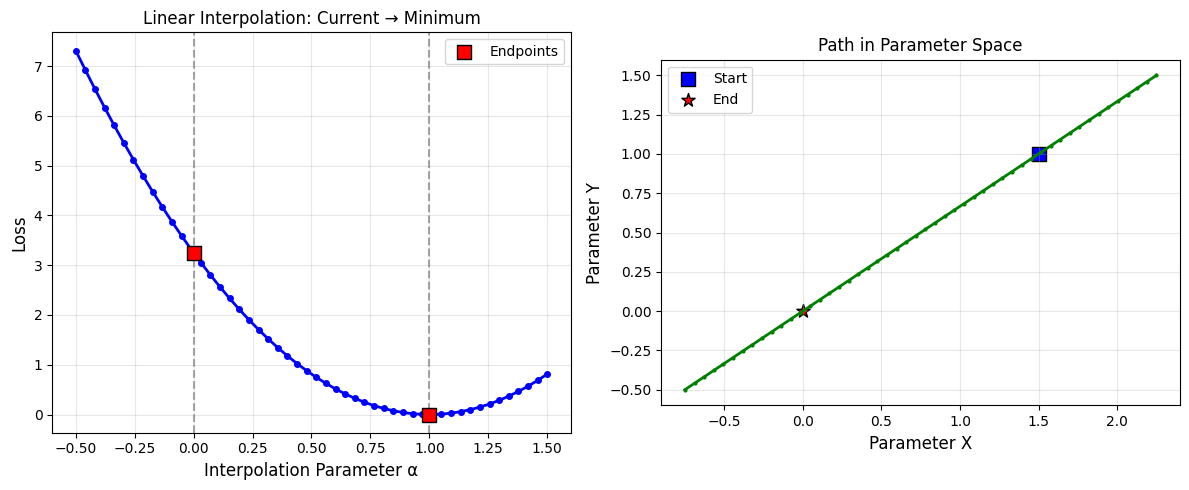

In [5]:
# Create linear interpolation slicer
linear_slicer = LinearInterpolationSlicer(model_wrapper_2d)

# Slice between current position and minimum
slice_data = linear_slicer.slice(
    start_point=point_current,
    end_point=point_minimum,
    n_samples=LINEAR_SAMPLES
)

# Create plot 
fig = plot_slices(
    slice_data=slice_data,
    title="Linear Interpolation: Current → Minimum",
)
plt.show()

## 4. Axis-Parallel Slicing: Parameter-wise Analysis

Axis-parallel slicing varies each parameter independently while keeping all others fixed. This reveals how individual parameters contribute to the loss function and helps identify the most sensitive parameters. By sampling multiple focus points across the parameter space, we can understand how the parameter sensitivity varies at different locations in the loss landscape.

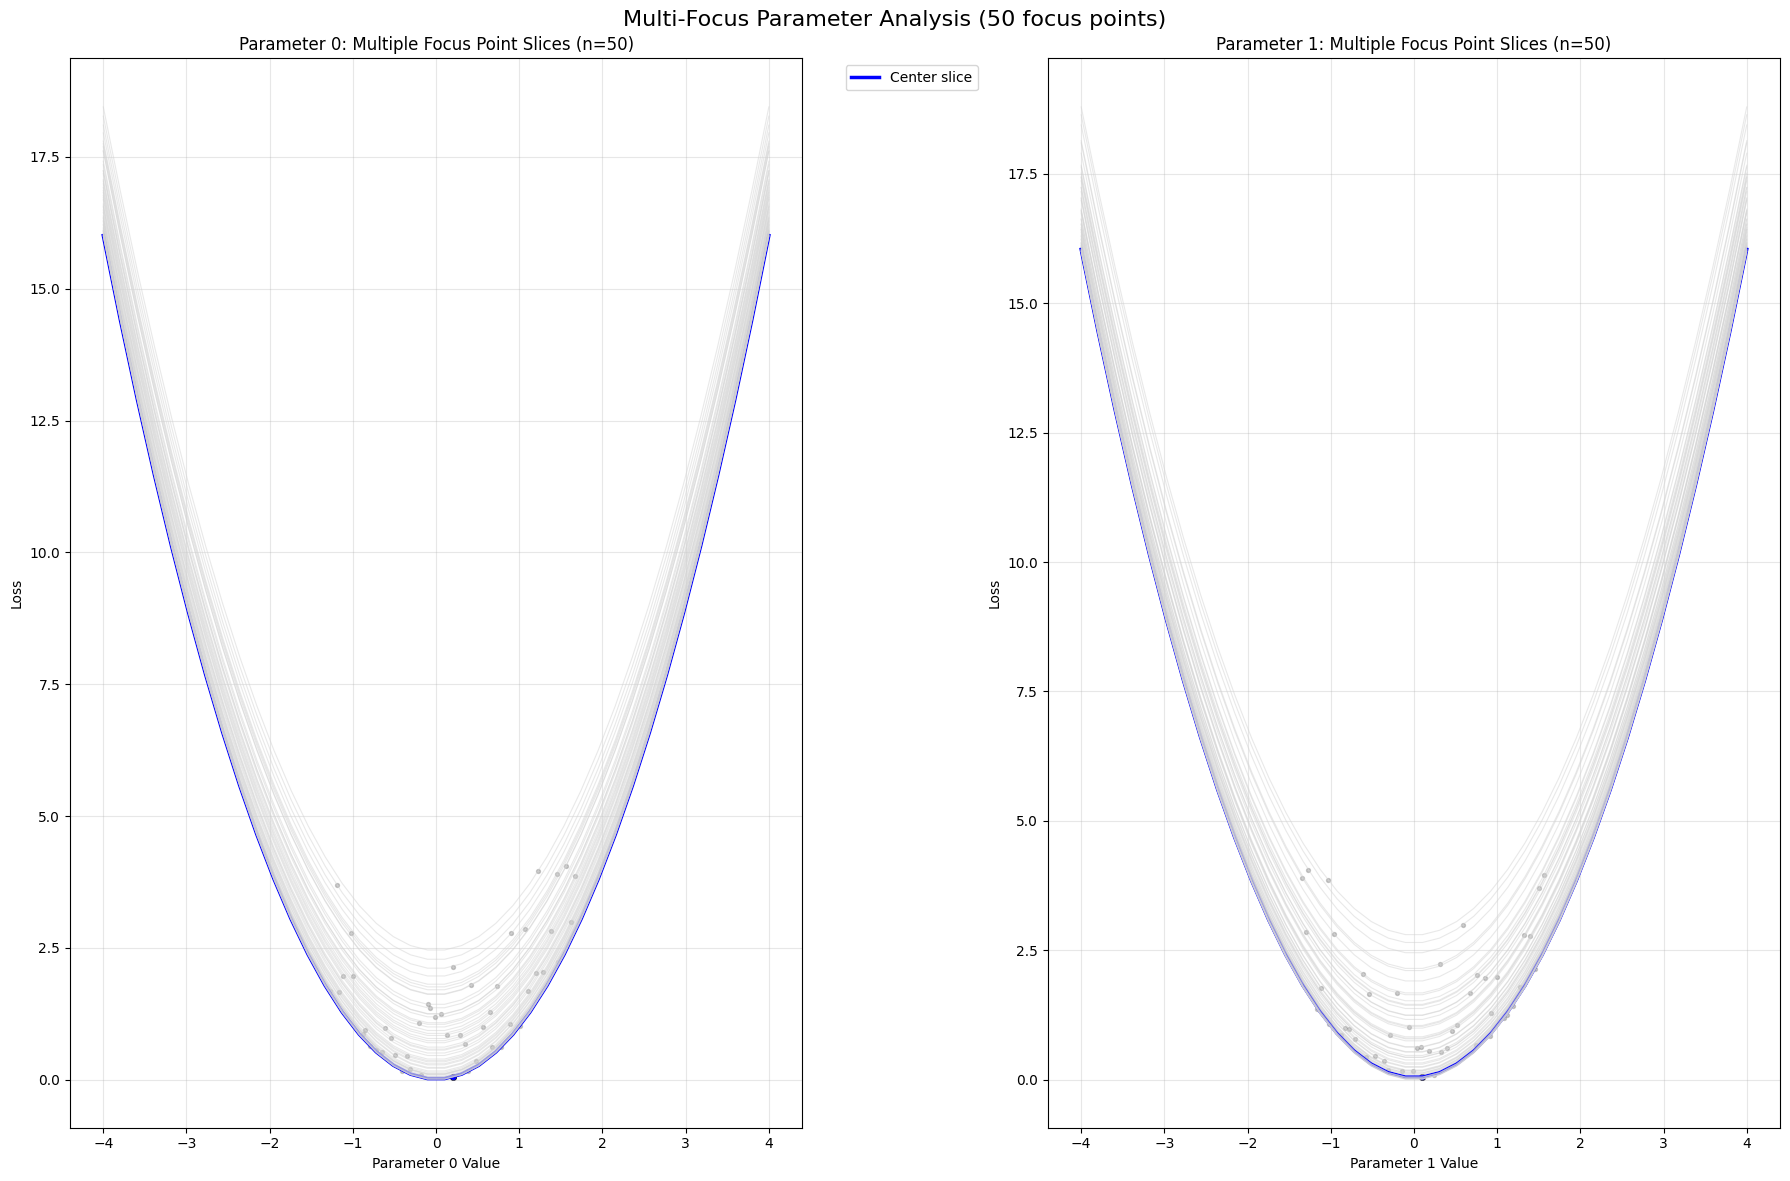

In [6]:
# Demonstrate axis-parallel slicing with multiple focus points
axis_slicer = AxisParallelSlicer(model_wrapper_2d)

# Generate multiple focus points and slice around each one
focus_slice_data = axis_slicer.sample_focus_points_and_slice(
    center_point=None,  # Use current model parameters as center
    n_points=50,        # Generate 50 focus points for better coverage
    sampling_method="lhs",  # Latin Hypercube Sampling for good coverage
    radius=1.5,         # Sampling radius around center
    bounds=(-PARAM_RANGE, PARAM_RANGE),
    n_samples_per_slice=SLICING_STEPS,
    bounds_mode="absolute",
    seed=42  # For reproducible results
)

fig = plot_slices(
    slice_data=focus_slice_data,
)
plt.show()


## 5. Random Direction Slicing: 2D Loss Landscapes

Random direction slicing explores the loss landscape along randomly chosen directions, providing 2D approximations of the loss landscape topology around a point in parameter space. This is accomplished by sampling two random direction vectors and computing loss on the plane they define.

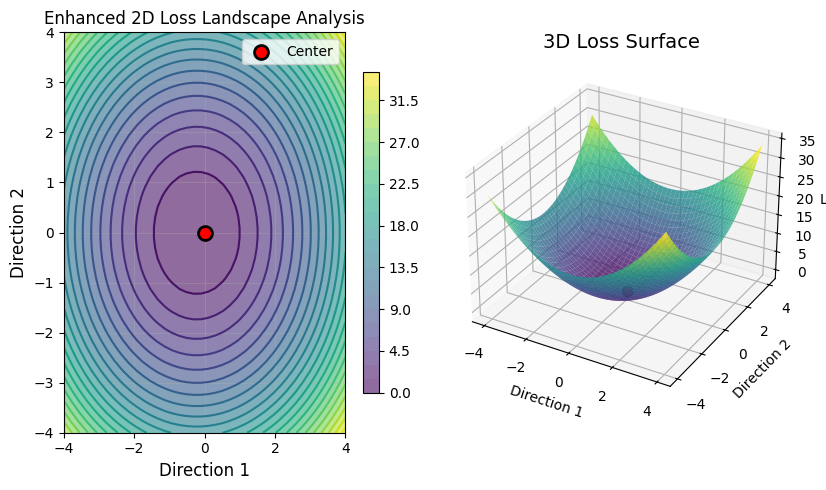

In [ ]:
# Create random direction slicer
random_slicer = RandomDirectionSlicer(model_wrapper_2d)

# Perform 2D random direction slicing
random_slice_data = random_slicer.slice(
    center_point=None,  # Use current model parameters
    n_samples=SLICING_STEPS,
    x_range=(-PARAM_RANGE, PARAM_RANGE),
    y_range=(-PARAM_RANGE, PARAM_RANGE),
    normalize_directions=True,
    ensure_orthogonal=True
)

# Visualize the 2D loss landscape
fig = plot_slices(
    slice_data=random_slice_data,
    title="2D Loss Landscape",
)
plt.show()
